# 数据读取

In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('D:\code\Github\data\AcademicTrendsAnalysis/arxiv-metadata-oai-snapshot.json', ['id', 'abstract', 'categories', 'comments'])


In [3]:
df_categories = pd.read_csv('D:\code\Github\data\AcademicTrendsAnalysis\categories.csv')

In [4]:
data.head()

,id,abstract,categories,comments
0,0704.0001,A fully differential calculation in perturba...,hep-ph,"37 pages, 15 figures; published version"
1,0704.0002,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,To appear in Graphs and Combinatorics
2,0704.0003,The evolution of Earth-Moon system is descri...,physics.gen-ph,"23 pages, 3 figures"
3,0704.0004,We show that a determinant of Stirling cycle...,math.CO,11 pages
4,0704.0005,In this paper we show how to compute the $\L...,math.CA math.FA,None


# 提取论文的页数，图表数量  
*使用内置函数*.str.extract(pat)要比apply更快和高效

## 抽取所有论文的页数  
- 将comments转换成pd.string类行来方便使用str.函数


In [5]:
# 将评论转换成pd.string类行
data.comments = data.comments.astype('string')
pat = '(\d+) pages'
data['pages'] = data.comments.str.extract(pat=pat)

- 论文平均页数17页，做多的11232页，大部分（75%）在22页以内

In [6]:
data.pages.dropna(how = 'any').astype(int).describe().astype(int)

count    1089208
mean          17
std           22
min            0
25%            8
50%           13
75%           22
max        11232
Name: pages, dtype: int32

- 发现最小的论文页数是0，与baseline不太一样，查看原因发现，是由于部分论文的comment使用了小数等不规则形式

In [8]:
data.loc[data.pages == '0'].head()

,id,abstract,categories,comments,pages
166453,1001.1165,"In this paper, we obtain an exact formula fo...",cond-mat.str-el cond-mat.supr-con,"4.0 pages + supplementary material, published ...",0
169447,1001.4159,We propose a simple three-body model of an a...,quant-ph physics.atom-ph,"0 pages, 10 figures, to be published in Phys. ...",0
345355,1205.6354,A Coulomb impurity placed in an undoped Weyl...,cond-mat.mes-hall hep-th nucl-th,"4+0 pages, extra references added",0
375597,1210.1803,A Coulomb impurity placed in an undoped Weyl...,cond-mat.mes-hall hep-th,"4+0 pages, 1 figure, generalization of arXiv:1...",0
410837,1302.6497,B. Szegedy [Edge coloring models and reflect...,math.CO math.AG,Some typos and inconsistencies have been fixed...,0


## 按类别统计论文页数  
- 使用`.str.split()`进行字符分割  
- 属于多个类别的论文，只使用第一个类别

将论文与类别数据进行表连接

In [9]:
data['categories'] = data.categories.str.split(' ',expand = True)[0]
data_merge = data.merge(df_categories,how='left',on='categories').drop_duplicates(['id','group_name'],keep = 'first')
data_merge.head()

,id,abstract,categories,comments,pages,group_name,archive_name,archive_id,category_name,category_description
0,0704.0001,A fully differential calculation in perturba...,hep-ph,"37 pages, 15 figures; published version",37,Physics,High Energy Physics - Phenomenology,hep-ph,High Energy Physics - Phenomenology,Description coming soon
1,0704.0002,"We describe a new algorithm, the $(k,\ell)$-...",math.CO,To appear in Graphs and Combinatorics,<NA>,Mathematics,Mathematics,Mathematics,Combinatorics,"Discrete mathematics, graph theory, enumeratio..."
2,0704.0003,The evolution of Earth-Moon system is descri...,physics.gen-ph,"23 pages, 3 figures",23,Physics,Physics,physics,General Physics,Description coming soon
3,0704.0004,We show that a determinant of Stirling cycle...,math.CO,11 pages,11,Mathematics,Mathematics,Mathematics,Combinatorics,"Discrete mathematics, graph theory, enumeratio..."
4,0704.0005,In this paper we show how to compute the $\L...,math.CA,<NA>,<NA>,Mathematics,Mathematics,Mathematics,Classical Analysis and ODEs,"Special functions, orthogonal polynomials, har..."


删除data，节约内存

In [10]:
del data
import gc
gc.collect()

2052

- **需要将pages转换成Int数据类型，才能进行聚合运算**

In [12]:
data_merge.pages = data_merge.pages.astype('string').astype('Int64')

### 不同大类论文的平均页数  
- 经济学，数学，统计学最多
- 计算机科学居然排到倒数第二

Text(0.5, 1.0, '不同大类论文的平均页数')

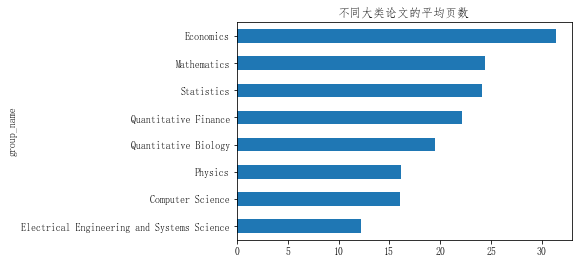

In [17]:
plt.rcParams['font.sans-serif']=['fangsong']
data_merge.groupby('group_name')['pages'].mean().sort_values().plot(kind = 'barh')
plt.title('不同大类论文的平均页数')

### 计算机科学领域的页数排名  
- 可以看到计算机效能，新兴科技，系统控制三个领域的平均页数最多

Text(0.5, 1.0, '计算机不同领域论文的平均页数')

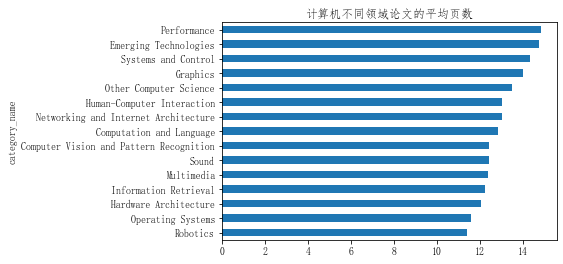

In [36]:
data_merge.query('group_name == "Computer Science"').groupby('category_name')['pages'].mean().sort_values().head(15).plot(kind = 'barh')
plt.title('计算机不同领域论文的平均页数')

## 对论文图表个数进行统计

In [29]:
pat = '(\d+) figures'
data_merge['figure'] = data_merge.comments.str.extract(pat)
data_merge.figure.dropna(how = 'any').astype(int).describe().astype(int)

count    647810
mean          7
std          10
min           0
25%           4
50%           6
75%           9
max        4989
Name: figure, dtype: int32

### 不同大类论文图表数量的统计  
- 可以看到每个大类的平均图表数量相差都不大  
- 图表数量都在7-8之间

Text(0.5, 1.0, '不同大类论文的图表数量')

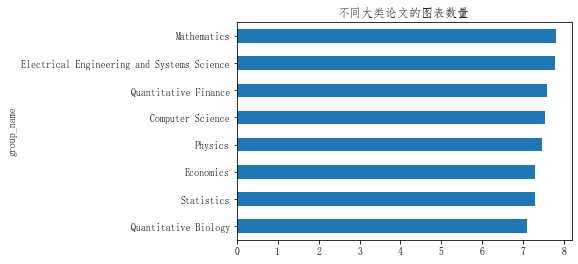

In [37]:
data_merge.figure = data_merge.figure.astype('string').astype('Int64')
data_merge.groupby('group_name')['figure'].mean().sort_values().plot(kind = 'barh')
plt.title('不同大类论文的图表数量')

### 计算机领域论文图标数量（前15）
- 可以看到密码安全学、机器学习两个领域的图数量最多



Text(0.5, 1.0, '计算机不同领域论文的平均图表数量')

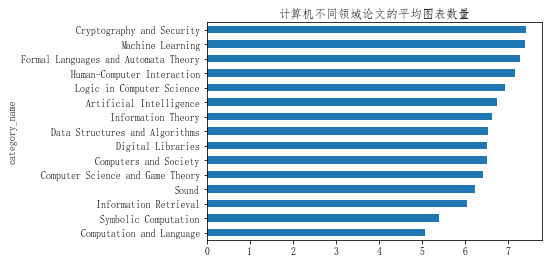

In [41]:
data_merge.query('group_name == "Computer Science"').groupby('category_name')['figure'].mean().sort_values().head(15).plot(kind = 'barh')
plt.title('计算机不同领域论文的平均图表数量')

## 统计有开源代码的论文数量  
- str.contains(pat)判断字符串是否包含pat
- str.findall(pat)匹配所有字符，放入列表中

In [34]:
data_with_code = data_merge[
    (data_merge.comments.str.contains('github')==True)|
                      (data_merge.abstract.str.contains('github')==True)
]
data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')

# 使用正则表达式匹配论文
pattern = '[a-zA-z]+://github[^\s]*'
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(lambda x : 0 if len(x) <1 else 1)

### 统计不同大类论文包含有开源代码的论文数量  
- 可以看到计算机科学拥有的开源论文数量最多，共有7000篇左右

Text(0.5, 1.0, '不同大类论文包含开放代码的论文数量')

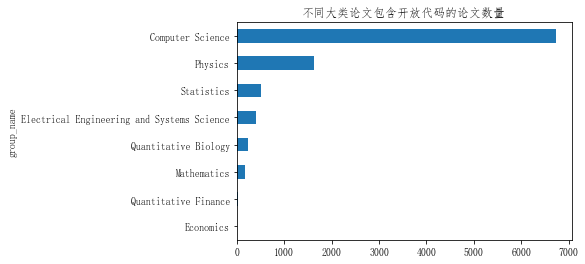

In [38]:
data_with_code.groupby(['group_name'])['code_flag'].count().sort_values().plot(kind='barh')
plt.title('不同大类论文包含开放代码的论文数量')

### 统计计算机科学包含代码论文的数量（前15个）  
- 计算机工程，数字图书馆，多媒体的的开放代码论文数量最多

Text(0.5, 1.0, '计算机不同领域开放代码的论文数量')

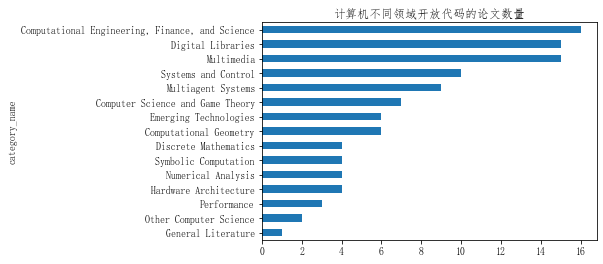

In [44]:
data_with_code.query('group_name == "Computer Science"').groupby('category_name')['code_flag'].count().sort_values().head(15).plot(kind = 'barh')
plt.title('计算机不同领域开放代码的论文数量')